In [ ]:
"""
AI312 NLP Final Project  
Title: Hate Speech Classification with GRU & BERT  
Team Members: Shahed Berkdar, Remas Rabah, Reem Aljuwayd, Sana Mouazen 
Date: May 2025  

"""

# 1. Preprocessing, POS Tagging and Syntax-Aware Features

In [2]:
"""
Preprocessing and Feature Engineering for Hate Speech Dataset

This script performs the following:
1. Cleans raw tweet text (removes URLs, mentions, hashtags, and punctuation).
2. Lemmatizes the cleaned text using WordNet.
3. Extracts POS features: counts and POS n-grams.
4. Saves the processed dataset to CSV.

"""

import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer
from nltk import pos_tag, bigrams, trigrams

# Download required NLTK packages
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Initialize preprocessing tools
lemmatizer = WordNetLemmatizer()
tokenizer = TreebankWordTokenizer()


def clean_text(text):
    """
    Remove URLs, mentions, hashtags, and non-alphabetic characters from text.

    Args:
        text (str): Raw tweet text.

    Returns:
        str: Cleaned and lowercased text.
    """
    text = re.sub(r"http\S+|@\S+|#[A-Za-z0-9_]+|[^A-Za-z\s]", '', text)
    return text.strip().lower()


def lemmatize(text):
    """
    Lemmatize each token in the input text using WordNet.

    Args:
        text (str): Cleaned tweet text.

    Returns:
        str: Lemmatized sentence.
    """
    return " ".join([lemmatizer.lemmatize(word) for word in tokenizer.tokenize(text)])


def add_pos_features(text):
    """
    Extract POS features including counts and unigrams/bigrams/trigrams.

    Args:
        text (str): Lemmatized tweet text.

    Returns:
        dict: POS counts and n-gram strings.
    """
    tokens = tokenizer.tokenize(text)
    tags = pos_tag(tokens)

    pos_unigrams = " ".join([tag for _, tag in tags])
    pos_bigrams = " ".join(["_".join(pair) for pair in bigrams([tag for _, tag in tags])])
    pos_trigrams = " ".join(["_".join(tri) for tri in trigrams([tag for _, tag in tags])])

    return {
        "noun_count": sum(1 for _, t in tags if t.startswith('NN')),
        "verb_count": sum(1 for _, t in tags if t.startswith('VB')),
        "adj_count": sum(1 for _, t in tags if t.startswith('JJ')),
        "pos_unigrams": pos_unigrams,
        "pos_bigrams": pos_bigrams,
        "pos_trigrams": pos_trigrams
    }


# Load dataset
df = pd.read_csv("labeled_data.csv")[['tweet', 'class']].dropna()

# Apply preprocessing and feature extraction
df['cleaned'] = df['tweet'].apply(clean_text).apply(lemmatize)
pos_df = df['cleaned'].apply(lambda x: pd.Series(add_pos_features(x)))

# Merge original and POS features
df = pd.concat([df, pos_df], axis=1)
df.rename(columns={"class": "label"}, inplace=True)

# Save to CSV
df.to_csv("preprocessed_with_pos_features.csv", index=False)
print("Preprocessing completed and saved to preprocessed_with_pos_features.csv")

# Show examples
print("\nSample cleaned rows:")
print(df[['tweet', 'cleaned', 'noun_count', 'verb_count', 'adj_count']].head())

Preprocessing completed and saved to preprocessed_with_pos_features.csv

Sample cleaned rows:
                                               tweet  \
0  !!! RT @mayasolovely: As a woman you shouldn't...   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...   

                                             cleaned  noun_count  verb_count  \
0  rt a a woman you shouldnt complain about clean...           4           6   
1  rt boy dat coldtyga dwn bad for cuffin dat hoe...           9           0   
2  rt dawg rt you ever fuck a bitch and she start...           5           5   
3                          rt she look like a tranny           2           1   
4  rt the shit you hear about me might be true or...           2           6   

   adj_count  
0          0  
1          2  
2          0  
3          0  
4          2 

In [3]:
# POS unigrams tag features examples
print("POS unigrams:")
df[['pos_unigrams']].head()

POS unigrams:


,pos_unigrams
0,VB DT DT NN PRP VBP VB IN VBG RP PRP$ NN VBZ D...
1,NN NN NN NN NN JJ IN NN NN NN IN DT JJ NN
2,NN NN NN PRP RB VBD DT NN CC PRP VBP TO VB PRP...
3,NN PRP VBP IN DT NN
4,VB DT NN PRP VBP IN PRP MD VB JJ CC PRP MD VB ...


In [4]:
# POS bigrams tag features examples
print("POS bigrams:")
df[['pos_bigrams']].head()

POS bigrams:


,pos_bigrams
0,VB_DT DT_DT DT_NN NN_PRP PRP_VBP VBP_VB VB_IN ...
1,NN_NN NN_NN NN_NN NN_NN NN_JJ JJ_IN IN_NN NN_N...
2,NN_NN NN_NN NN_PRP PRP_RB RB_VBD VBD_DT DT_NN ...
3,NN_PRP PRP_VBP VBP_IN IN_DT DT_NN
4,VB_DT DT_NN NN_PRP PRP_VBP VBP_IN IN_PRP PRP_M...


In [5]:
# POS trigrams tag features examples
print("POS trigrams:")
df[['pos_trigrams']].head()

POS trigrams:


,pos_trigrams
0,VB_DT_DT DT_DT_NN DT_NN_PRP NN_PRP_VBP PRP_VBP...
1,NN_NN_NN NN_NN_NN NN_NN_NN NN_NN_JJ NN_JJ_IN J...
2,NN_NN_NN NN_NN_PRP NN_PRP_RB PRP_RB_VBD RB_VBD...
3,NN_PRP_VBP PRP_VBP_IN VBP_IN_DT IN_DT_NN
4,VB_DT_NN DT_NN_PRP NN_PRP_VBP PRP_VBP_IN VBP_I...


# 2. GRU Model: Training, Evaluation and Saving the Model

In [6]:
"""
GRU Text Classification Model  

This script performs the following:
1. Loads and preprocesses the cleaned tweet dataset.
2. Tokenizes and pads the sequences.
3. Builds and trains a GRU-based neural network for 3-class classification.
4. Evaluates the model with metrics and a confusion matrix.
5. Saves the trained model.
"""

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


# Load the preprocessed dataset containing cleaned tweets and labels
df = pd.read_csv("preprocessed_with_pos_features.csv")[['cleaned', 'label']].dropna()
texts = df['cleaned'].values
labels = to_categorical(df['label'].values, num_classes=3)

# Tokenize the text using Keras tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=100)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)


def build_gru_model(vocab_size=10000, embed_dim=128, gru_units=64, input_length=100, num_classes=3):
    """
    Builds and compiles a GRU-based neural network for text classification.

    Parameters:
        vocab_size (int): Size of the vocabulary for the embedding layer.
        embed_dim (int): Dimension of the embedding vectors.
        gru_units (int): Number of GRU units.
        input_length (int): Length of padded sequences.
        num_classes (int): Number of output categories.

    Returns:
        tf.keras.Model: A compiled GRU classification model.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=input_length),
        tf.keras.layers.GRU(gru_units, return_sequences=False),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Instantiate and train the GRU model
model = build_gru_model()
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Predict and evaluate the GRU model
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Print evaluation results
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

# Save the trained GRU model
model.save("gru_model.h5")
print("GRU model saved as gru_model.h5")

Epoch 1/5
620/620 [==============================] - 62s 88ms/step - loss: 0.3672 - accuracy: 0.8668 - val_loss: 0.2738 - val_accuracy: 0.9021
Epoch 2/5
620/620 [==============================] - 52s 84ms/step - loss: 0.2228 - accuracy: 0.9206 - val_loss: 0.2966 - val_accuracy: 0.9017
Epoch 3/5
620/620 [==============================] - 59s 95ms/step - loss: 0.1671 - accuracy: 0.9402 - val_loss: 0.3253 - val_accuracy: 0.8906
Epoch 4/5
620/620 [==============================] - 57s 93ms/step - loss: 0.1217 - accuracy: 0.9561 - val_loss: 0.3996 - val_accuracy: 0.8847
Epoch 5/5
155/155 [==============================] - 5s 28ms/step
[[  62  194   26]
 [  76 3593  129]
 [  15  140  719]]
              precision    recall  f1-score   support

           0       0.41      0.22      0.29       282
           1       0.91      0.95      0.93      3798
           2       0.82      0.82      0.82       874

    accuracy                           0.88      4954
   macro avg       0.71      0.66  

## Confusion Matrix Visualization

155/155 [==============================] - 4s 28ms/step


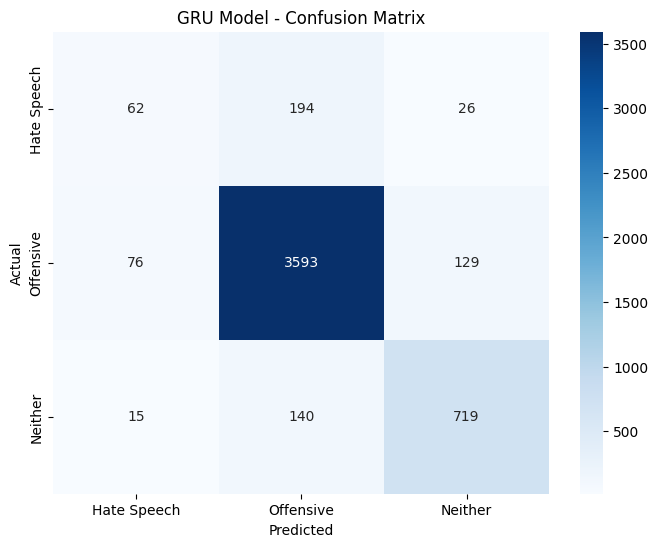

In [7]:
"""
Visualize GRU model performance using confusion matrix.
"""
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Recompute predictions
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Create confusion matrix 
cm = confusion_matrix(y_true, y_pred)
labels = ['Hate Speech', 'Offensive', 'Neither']

# Plot confusion matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('GRU Model - Confusion Matrix')

plt.show()

# 3. BERT Model: Training, Visualization and Saving the Model

In [8]:
"""
BERT Text Classification Model

This script performs the following:
1. Loads and preprocesses the cleaned tweet dataset.
2. Tokenizes the text using a BERT tokenizer.
3. Builds and trains a BERT-based model for 3-class classification.
4. Evaluates the model using predicted vs actual labels.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
)

# Load and preprocess the dataset containing cleaned text and labels
df = pd.read_csv("preprocessed_with_pos_features.csv")[['cleaned', 'label']].dropna()
df.rename(columns={"cleaned": "text", "label": "labels"}, inplace=True)

# Convert pandas DataFrame to HuggingFace Dataset format
dataset = Dataset.from_pandas(df)

# Load pre-trained BERT tokenizer
tokenizer_bert = BertTokenizerFast.from_pretrained("bert-base-uncased")

def tokenize(example):
    """
    Tokenizes the input text using BERT tokenizer.

    Parameters:
        example (dict): A dictionary containing a 'text' field.

    Returns:
        dict: Tokenized output with input_ids and attention_mask.
    """
    return tokenizer_bert(example['text'], truncation=True, padding='max_length', max_length=128)

# Tokenize the entire dataset
tokenized = dataset.map(tokenize, batched=True)

# Split the dataset into training and testing sets (80/20 split)
train_test = tokenized.train_test_split(test_size=0.2)

# Load the pre-trained BERT model with classification head (3 output classes)
model_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model_bert.to("cuda")  # Move model to GPU if available

# Define training configuration
training_args = TrainingArguments(
    output_dir="bert_model",               # Directory to save model checkpoints
    num_train_epochs=3,                    # Number of training epochs
    per_device_train_batch_size=16,        # Batch size for training
    per_device_eval_batch_size=64,         # Batch size for evaluation
    logging_dir="bert_logs",               # Logging directory
    logging_steps=10,                      # Log every 10 steps
    disable_tqdm=False                     # Enable progress bars
)

# Create HuggingFace Trainer instance
trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_test["train"],
    eval_dataset=train_test["test"],
)

# Train the BERT model
trainer.train()

# Make predictions on the test set
predictions = trainer.predict(train_test["test"])
bert_logits = predictions.predictions

# Convert logits to predicted class labels
y_pred_bert = np.argmax(bert_logits, axis=1)
y_true_bert = np.array(train_test["test"]["labels"])

Map: 100%|██████████████████████████████████████████████████████████████| 24766/24766 [00:05<00:00, 4790.10 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.805700
20,0.633800
30,0.505700
40,0.503800
50,0.400100
60,0.379000
70,0.497600
80,0.395100
90,0.313100
100,0.436400



Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.39      0.43       282
           1       0.94      0.95      0.94      3845
           2       0.87      0.89      0.88       827

    accuracy                           0.91      4954
   macro avg       0.76      0.74      0.75      4954
weighted avg       0.90      0.91      0.90      4954


Confusion Matrix:
 [[ 111  151   20]
 [ 120 3640   85]
 [   5   89  733]]


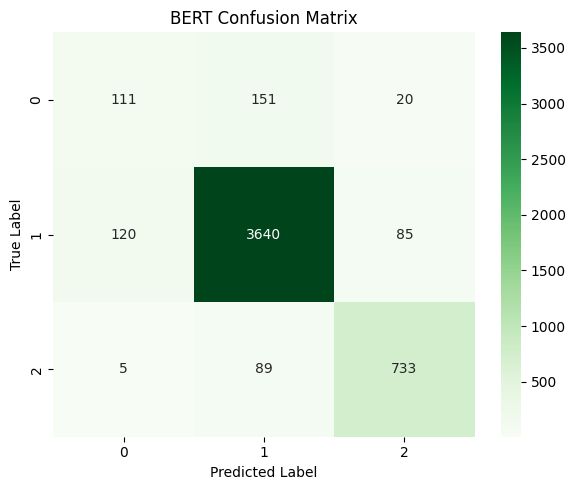

('bert_model\\tokenizer_config.json',
 'bert_model\\special_tokens_map.json',
 'bert_model\\vocab.txt',
 'bert_model\\added_tokens.json',
 'bert_model\\tokenizer.json')

In [9]:
# Evaluation of BERT Model

# Print a detailed classification report (precision, recall, f1-score)
print("\nClassification Report:\n", classification_report(y_true_bert, y_pred_bert))

# Print the raw confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_true_bert, y_pred_bert))

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_true_bert, y_pred_bert), annot=True, fmt='d', cmap='Greens')
plt.title("BERT Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Save Trained Model

# Save the trained BERT model and tokenizer to the specified directory
model_bert.save_pretrained("bert_model")
tokenizer_bert.save_pretrained("bert_model")

# 4. ROC Curve Comparison

155/155 [==============================] - 4s 28ms/step


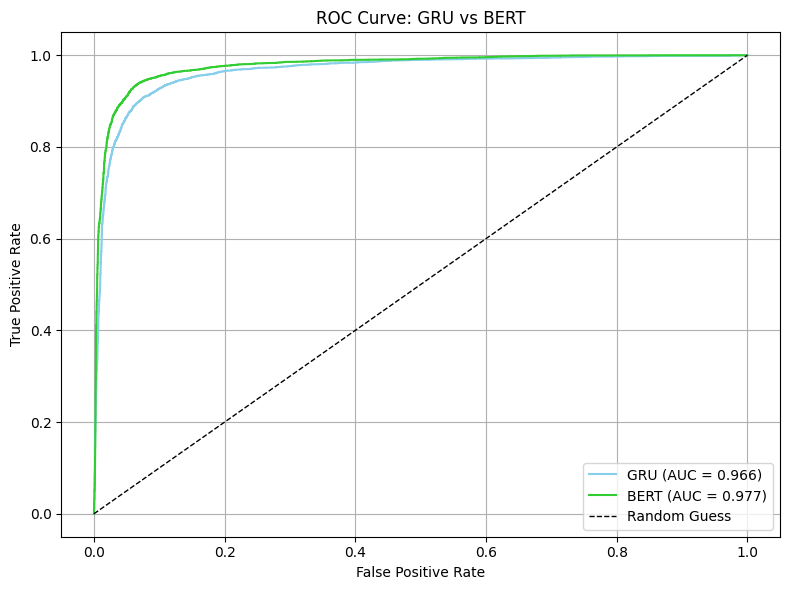

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from scipy.special import softmax

# Binarize true labels for ROC
y_true_gru = np.argmax(y_test, axis=1)
y_test_bin = label_binarize(y_true_gru, classes=[0, 1, 2])

# GRU predicted probabilities (already softmaxed)
y_score_gru = model.predict(X_test)

# ROC for GRU
fpr_gru, tpr_gru, _ = roc_curve(y_test_bin.ravel(), y_score_gru.ravel())
roc_auc_gru = auc(fpr_gru, tpr_gru)

# BERT logits → softmax
bert_probs = softmax(np.array(bert_logits), axis=1)

# ROC for BERT
y_test_bin_bert = label_binarize(y_true_bert, classes=[0, 1, 2])
fpr_bert, tpr_bert, _ = roc_curve(y_test_bin_bert.ravel(), bert_probs.ravel())
roc_auc_bert = auc(fpr_bert, tpr_bert)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_gru, tpr_gru, color='skyblue', label=f"GRU (AUC = {roc_auc_gru:.3f})")
plt.plot(fpr_bert, tpr_bert, color='limegreen', label=f"BERT (AUC = {roc_auc_bert:.3f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1, label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: GRU vs BERT')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


## Saving the Better Model

In [13]:
# Compare AUC Scores & Save Best Model
if roc_auc_bert > roc_auc_gru:
    print(f"[INFO] BERT performed better (AUC: {roc_auc_bert:.4f})")

    # Save the BERT model and tokenizer to the 'final_model' directory
    model_bert.save_pretrained("final_model")
    tokenizer_bert.save_pretrained("final_model")
else:
    print(f"[INFO] GRU performed better (AUC: {roc_auc_gru:.4f})")

    # Save the GRU model as a Keras .h5 file
    model.save("final_model.h5")


[INFO] BERT performed better (AUC: 0.9769)
